In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox,Label
import plotly as ply
from dance_sim_tools import trace_objects,utility
from dance_sim_tools.utility import histogram_draw_to_parameters as htp
from dance_sim_tools.utility import draw_reversal_distances_tm
from dance_sim_tools.ipywidget_helpers import slider,intslider
import pandas as pd
import dance_sim_tools.trace_objects as trace_objects
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
import matplotlib.gridspec

In [2]:
def rads_to_bls(theta):
    return np.degrees(theta)*(np.pi/9)/2.4
def degs_to_bls(theta):
    return theta*(np.pi/9)/2.4
trials_per_cond = [23,21,20]
cond_strs = ['1LED','2LED60','2LED90']

# plt.figure(figsize=(8,8))
# x = np.linspace(0,8*np.pi,100)
# y = np.pi*np.sin(x)
# y_shifted = np.pi*np.sin(x)+np.pi/19.
# y_reshifted = theta_normalize_rad(y_shifted)
# plt.plot(x,y,'r')
# plt.plot(x,y_shifted,'purple')
# plt.plot(x,y_reshifted,'y')
# plt.show()

In [3]:
def theta_normalize_rad(theta,min_val):
    print('min_val',min_val) 
    return theta-(min_val+np.pi)



def plot_envelopes(condition,fly_num,t_window,d_max,show_led,include_wraps=True):
    
    num_flies = trials_per_cond[condition]
    
    file_loc = 'UMAP_data_af/'
    
    filename_l = file_loc+'RE_l_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    revs_l_rad = pd.read_csv(filename_l).values.T[0]
    
    filename_t = file_loc+'RE_t_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    revs_t = pd.read_csv(filename_t).values.T[0]
    
    af_file_loc = 'UMAP_data_af/'
    theta_af_filename = af_file_loc+'theta_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    t_af_filename = af_file_loc+'t_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    theta_af_signal_rads=pd.read_csv(theta_af_filename).values.T[0]
     
    theta_signal_min = np.min(theta_af_signal_rads)

    theta_af_signal = rads_to_bls(theta_af_signal_rads)
    revs_l = rads_to_bls(revs_l_rad)
    t_af_signal = pd.read_csv(t_af_filename).values.T[0]    
 
  
    if include_wraps:
        #We go find the inds of theta_af_signal where the theta signal wraps
        wrap_loc_inds = np.abs(np.gradient(theta_af_signal_rads))>(np.pi-np.radians(3))    
        wraps_l = theta_af_signal[wrap_loc_inds]
        wraps_t = t_af_signal[wrap_loc_inds]  
        
   
    shift = rads_to_bls(2*np.pi/4)
    
    if ((fly_num==22)&(condition==0)):
        theta_af_signal -= shift
        revs_l -= shift
      
    if show_led:
        led_file_loc = 'activation_period_data/'+\
            cond_strs[condition]+'/'+cond_strs[condition]+'_'+str(fly_num+1)
        led_filename = led_file_loc+'/data.txt'
        ledt_filename = led_file_loc+'/time.txt'

        ledt = pd.read_csv(led_filename, header=0, usecols=[0]).values[1:,0].astype(float)/(1e9)
        ledt0 = ledt[0]
        ledt_shifted = ledt - ledt0
        ledt_min = np.divide(ledt_shifted,60) # to minutes
        ledt_min+=10 #led times should start at 10 and not 0 to match the theta signal times
        led_pins = pd.read_csv(led_filename, header=0, usecols=[6]).values[1:,0]

    # t_filename = '{theta/t}_du2_{cond_num}_{fly_num}.txt'
    plt.figure(figsize=(16,8))
    ax = plt.subplot(211)
    plt.plot(t_af_signal,theta_af_signal,'.',markersize=1,color='lightblue',zorder=0)
    
    if include_wraps:
        revs_t = np.hstack((revs_t,wraps_t))
        revs_l = np.hstack((revs_l,wraps_l))
        new_order = np.argsort(revs_t)
        revs_t = revs_t[new_order]
        revs_l = revs_l[new_order]
        
    plt.scatter(revs_t,revs_l,zorder=1)
   
    
    
    which_above_inds = (revs_l>0)
    
    plt.plot(revs_t[which_above_inds],revs_l[which_above_inds],color='purple')
    plt.plot(revs_t[~which_above_inds],revs_l[~which_above_inds],color='purple')
    
    plt.ylabel('Location (Body Lengths)')
    food_width = degs_to_bls(15.)
    
    
    #Food location bars
    if condition==0:
        plt.axhspan(-1*food_width/2,food_width/2, facecolor='g', alpha=0.1,label='food') 
    elif condition==1:
        theta_1_loc = -1*degs_to_bls(30.)
        theta_2_loc = degs_to_bls(30.)                
        plt.axhspan(theta_1_loc-1*food_width/2,theta_1_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
        plt.axhspan(theta_2_loc-1*food_width/2,theta_2_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
    
    elif condition==2:
        theta_1_loc = -1*degs_to_bls(45.)
        theta_2_loc = degs_to_bls(45.)                
        plt.axhspan(theta_1_loc-1*food_width/2,theta_1_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
        plt.axhspan(theta_2_loc-1*food_width/2,theta_2_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
    
    
    if show_led:
        plt.eventplot(ledt_min,color='r',linelengths=2*d_max,lineoffsets=0.,alpha=0.6,linewidths=1)
    
    plt.ylim([-1*d_max,1*d_max])
    plt.xlabel('Time (min)')
    plt.xlim([t_window[0],t_window[1]])




condition_toggle = widgets.RadioButtons(
    options=[('1F',0), ('2F 60',1), ('2F 90',2)],disabled=False,description='condition')     

show_led_toggle = widgets.RadioButtons(options=[('True',1),('False',0)],disabled=False,description='show_led')

#start,stop,step,init
sfly_sample = intslider('fly_num',0,22,1,0)
st_window = widgets.FloatRangeSlider(
    value = [50,55],
    min=50,
    max=55,
    step=0.5,
    orientation='horizontal',
    description='t_window'
)
sd_max = slider('d_max',15,45,1,rads_to_bls(7*np.pi/5))
include_wraps_toggle = widgets.RadioButtons(options=[('True',1),('False',0)],disabled=False,description='include_wraps')


sliders = [sfly_sample,condition_toggle,
           st_window,sd_max,show_led_toggle,include_wraps_toggle]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_envelopes, param_dict)



display(ui,out)

    
    
#plot_activation_trace(condition,fly_num)


Box(children=(Box(children=(IntSlider(value=0, continuous_update=False, description='fly_num', max=22),)), Box…

Output()

Then use the LED data to construct a time-varying light-on light-off signal.

Box(children=(Box(children=(IntSlider(value=0, continuous_update=False, description='fly_num', max=22),)), Box…

Output()

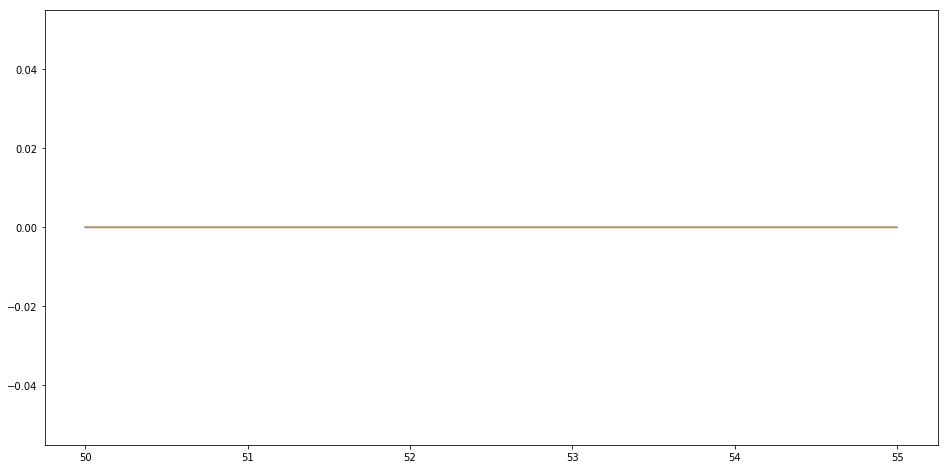

In [56]:
def plot_envelope_by_fly(fly_num,condition,d_max,show_led,include_wraps=True,nondecreasing=True):
    
    num_flies = trials_per_cond[condition]
    dt = 0.1
    
    file_loc = 'UMAP_data_af/'
    af_dur = 5.*60
    
    envelopes_over_time = np.zeros((num_flies,2,int(af_dur/dt))) #middle axis is top/bottom
    
    af_t = np.arange(0,af_dur,dt)*(1./60)+50.
    
    try:
        filename_l = file_loc+'RE_l_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
        revs_l = rads_to_bls(pd.read_csv(filename_l).values.T[0])

        filename_t = file_loc+'RE_t_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
        revs_t = pd.read_csv(filename_t).values.T[0]

        af_file_loc = 'UMAP_data_af/'
        t_af_filename = af_file_loc+'t_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
        t_af_signal = pd.read_csv(t_af_filename).values.T[0]    
        theta_af_filename = af_file_loc+'theta_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
        theta_af_signal_rads=pd.read_csv(theta_af_filename).values.T[0]
        theta_af_signal = rads_to_bls(theta_af_signal_rads)

        if include_wraps:
            #We go find the inds of theta_af_signal where the theta signal wraps
            wrap_loc_inds = np.abs(np.gradient(theta_af_signal_rads))>(np.pi-np.radians(2))    
            wraps_l = theta_af_signal[wrap_loc_inds]
            wraps_t = t_af_signal[wrap_loc_inds]  
            revs_t = np.hstack((revs_t,wraps_t))
            revs_l = np.hstack((revs_l,wraps_l))
            new_order = np.argsort(revs_t)
            revs_t = revs_t[new_order]
            revs_l = revs_l[new_order]

        
        which_above_inds = (revs_l>0)
        envelope_top = revs_l[which_above_inds]
        envelope_top_interp = np.interp(af_t,
                revs_t[which_above_inds], envelope_top)
        envelope_bottom = revs_l[~which_above_inds]
        envelope_bottom_interp = np.interp(af_t,
                revs_t[~which_above_inds], envelope_bottom)   


        if nondecreasing:
            #Find the first time the "search radius" crosses over and set all inds past that to that val
            first_cross_ind1 = np.where(np.abs(np.gradient(theta_af_signal_rads))>(np.pi-np.radians(3)))[0][0]
            try:
                ind1 = np.where(
                    envelope_top_interp-envelope_top_interp[0]>rads_to_bls(np.pi-np.radians(3))    
                    )[0][0]
            except(IndexError):
                ind1 = len(envelope_top_interp)
            try:
                ind2 = np.where(
                envelope_bottom_interp<rads_to_bls(-np.pi+np.radians(3))    
                )[0][0]
                first_cross_ind1 = min(ind1,ind2)
            except(IndexError):
                first_cross_ind1 = ind1
#             print('first_cross_ind1',first_cross_ind1,'/',len(theta_af_signal_rads))
#             first_cross_time = t_af_signal[first_cross_ind1]
#             print('first_cross_time',first_cross_time)
#             first_cross_ind2 = np.abs(af_t-first_cross_time).argmin()
#             print('first_cross_ind2',first_cross_ind2,'/',len(af_t))
#             print(envelope_top_interp[first_cross_ind2])
            envelope_top_interp[first_cross_ind1+1:] = envelope_top_interp[first_cross_ind1]
            envelope_bottom_interp[first_cross_ind1+1:] = envelope_bottom_interp[first_cross_ind1]
            

        envelopes_over_time[fly_num,0,:] = envelope_top_interp
        envelopes_over_time[fly_num,1,:] = envelope_bottom_interp
    except(FileNotFoundError):
        pass

#     plt.imshow(envelopes_over_time[:,0,:],aspect='auto')
    
    plt.figure(figsize=(16,8))
#     plt.plot(revs_t,revs_l)
    plt.plot(af_t,envelopes_over_time[fly_num,0,:],label='top')
    plt.plot(af_t,envelopes_over_time[fly_num,1,:],label='bottom')
    
    plt.plot(t_af_signal,theta_af_signal,'.',markersize=1,color='lightblue',zorder=0)
  
    
    plt.legend()
    
    plt.ylim([-1*d_max,1*d_max])
    plt.xlabel('Time (min)')
  
    
    plt.show()
    
    
      
sfly_sample = intslider('fly_num',0,22,1,0)
condition_toggle = widgets.RadioButtons(
    options=[('1F',0), ('2F 60',1), ('2F 90',2)],disabled=False,description='condition')     
sd_max = slider('d_max',15,45,1,30)
show_led_toggle = widgets.RadioButtons(options=[('True',1),('False',0)],disabled=False,description='show_led')
include_wraps_toggle = widgets.RadioButtons(options=[('True',1),('False',0)],disabled=False,description='include_wraps')
nondecreasing_toggle = widgets.RadioButtons(
    options=[('False',0),('True',1)],disabled=False,description='nondecreasing')

sliders = [sfly_sample,condition_toggle,sd_max,show_led_toggle,include_wraps_toggle,nondecreasing_toggle]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_envelope_by_fly, param_dict)



display(ui,out)


    
    
#plot_activation_trace(condition,fly_num)


In [58]:
def plot_envelope_rows(condition,d_max,show_led,include_wraps=True,nondecreasing=False):
    
    num_flies = trials_per_cond[condition]
    dt = 0.1
    
    file_loc = 'UMAP_data_af/'
    af_dur = 5.*60
    
    envelopes_over_time = np.zeros((num_flies,2,int(af_dur/dt))) #middle axis is top/bottom
    
    af_t = np.arange(0,af_dur,dt)*(1./60)+50.
    
    for fly_ind in range(num_flies):
    
        try:
            filename_l = file_loc+'RE_l_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            revs_l = rads_to_bls(pd.read_csv(filename_l).values.T[0])

            filename_t = file_loc+'RE_t_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            revs_t = pd.read_csv(filename_t).values.T[0]

            af_file_loc = 'UMAP_data_af/'
            t_af_filename = af_file_loc+'t_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            t_af_signal = pd.read_csv(t_af_filename).values.T[0]    
            theta_af_filename = af_file_loc+'theta_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            theta_af_signal_rads=pd.read_csv(theta_af_filename).values.T[0]
            theta_af_signal = rads_to_bls(theta_af_signal_rads)
            
            if include_wraps:
                #We go find the inds of theta_af_signal where the theta signal wraps
                wrap_loc_inds = np.abs(np.gradient(theta_af_signal_rads))>(np.pi-np.radians(2))    
                wraps_l = theta_af_signal[wrap_loc_inds]
                wraps_t = t_af_signal[wrap_loc_inds]  
                revs_t = np.hstack((revs_t,wraps_t))
                revs_l = np.hstack((revs_l,wraps_l))
                new_order = np.argsort(revs_t)
                revs_t = revs_t[new_order]
                revs_l = revs_l[new_order]

            
            which_above_inds = (revs_l>0)
            envelope_top = revs_l[which_above_inds]
            envelope_top_interp = np.interp(af_t,
                    revs_t[which_above_inds], envelope_top)
            envelope_bottom = revs_l[~which_above_inds]
            envelope_bottom_interp = np.interp(af_t,
            revs_t[~which_above_inds], envelope_bottom)    

            
            if nondecreasing:
                            
                #Find the first time the "search radius" crosses over and set all inds past that to that val))[0][0]
                try:
                    ind1 = np.where(
                        envelope_top_interp-envelope_top_interp[0]>rads_to_bls(np.pi-np.radians(3))    
                        )[0][0]
                except(IndexError):
                    ind1 = len(envelope_top_interp)-1
                try:
                    ind2 = np.where(
                    envelope_bottom_interp<rads_to_bls(-np.pi+np.radians(3))    
                    )[0][0]
                    first_cross_ind1 = min(ind1,ind2)
                except(IndexError):
                    first_cross_ind1 = ind1
                envelope_top_interp[first_cross_ind1+1:] = envelope_top_interp[first_cross_ind1]
                envelope_bottom_interp[first_cross_ind1+1:] = envelope_bottom_interp[first_cross_ind1]
                

        
        except(FileNotFoundError):
            envelopes_over_time[fly_ind,0,:] = np.nan
            envelopes_over_time[fly_ind,1,:] = np.nan
        
   
        envelopes_over_time[fly_ind,0,:] = envelope_top_interp
        envelopes_over_time[fly_ind,1,:] = envelope_bottom_interp
        
        
        
    
    plt.figure(figsize=(16,8))
   
    extent = (50,53,num_flies,0)
    image = envelopes_over_time[:,0,:]-envelopes_over_time[:,1,:]

    
    plt.imshow(image,aspect='auto',extent=extent,cmap='viridis_r')
    cbar=plt.colorbar()
    cbar.set_label('Reversal Range',rotation=270,labelpad=20)
    
    plt.ylabel('Fly')
    plt.xlabel('Time (min)')
  
    
    plt.show()
    
    
      
condition_toggle = widgets.RadioButtons(
    options=[('1F',0), ('2F 60',1), ('2F 90',2)],disabled=False,description='condition')     

show_led_toggle = widgets.RadioButtons(options=[('True',1),('False',0)],disabled=False,description='show_led')

sd_max = slider('d_max',15,45,1,30)

include_wraps_toggle = widgets.RadioButtons(options=[('True',1),('False',0)],disabled=False,description='include_wraps')

nondecreasing_toggle = widgets.RadioButtons(
    options=[('False',0),('True',1)],disabled=False,description='nondecreasing')


sliders = [condition_toggle,sd_max,show_led_toggle,include_wraps_toggle,nondecreasing_toggle]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_envelope_rows, param_dict)



display(ui,out)

    
    
#plot_activation_trace(condition,fly_num)


Box(children=(Box(children=(RadioButtons(description='condition', options=(('1F', 0), ('2F 60', 1), ('2F 90', …

Output()

In [98]:
def theta_normalize_rad(theta,min_val):
    print('min_val',min_val) 
    return theta-(min_val+np.pi)



def plot_cumulated_dist(condition,fly_num,t_window,d_max,show_led):
    
    num_flies = trials_per_cond[condition]
    
    file_loc = 'UMAP_data_af/'
    
    filename_l = file_loc+'RE_l_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    revs_l_rad = pd.read_csv(filename_l).values.T[0]
    
    filename_t = file_loc+'RE_t_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    revs_t = pd.read_csv(filename_t).values.T[0]
    
    af_file_loc = 'UMAP_data_af/'
    theta_af_filename = af_file_loc+'theta_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    t_af_filename = af_file_loc+'t_af_'+str(condition+1)+'_'+str(fly_num+1)+'.txt'
    theta_af_signal_rads=pd.read_csv(theta_af_filename).values.T[0]
     
    theta_signal_min = np.min(theta_af_signal_rads)

    theta_af_signal = rads_to_bls(theta_af_signal_rads)
    revs_l = rads_to_bls(revs_l_rad)
    t_af_signal = pd.read_csv(t_af_filename).values.T[0]    
 
  
    #We go find the inds of theta_af_signal where the theta signal wraps
    wrap_loc_inds = np.abs(np.gradient(theta_af_signal_rads))>(np.pi-np.radians(3))    
    wraps_l = theta_af_signal[wrap_loc_inds]
    wraps_t = t_af_signal[wrap_loc_inds]  
        

    shift = rads_to_bls(2*np.pi/4)
    
    if ((fly_num==22)&(condition==0)):
        theta_af_signal -= shift
        revs_l -= shift
      
    if show_led:
        led_file_loc = 'activation_period_data/'+\
            cond_strs[condition]+'/'+cond_strs[condition]+'_'+str(fly_num+1)
        led_filename = led_file_loc+'/data.txt'
        ledt_filename = led_file_loc+'/time.txt'

        ledt = pd.read_csv(led_filename, header=0, usecols=[0]).values[1:,0].astype(float)/(1e9)
        ledt0 = ledt[0]
        ledt_shifted = ledt - ledt0
        ledt_min = np.divide(ledt_shifted,60) # to minutes
        ledt_min+=10 #led times should start at 10 and not 0 to match the theta signal times
        led_pins = pd.read_csv(led_filename, header=0, usecols=[6]).values[1:,0]

    # t_filename = '{theta/t}_du2_{cond_num}_{fly_num}.txt'
    plt.figure(figsize=(16,8))
    ax = plt.subplot(211)
    plt.plot(t_af_signal,theta_af_signal,'.',markersize=1,color='lightblue',zorder=0)
    
    
    revs_t = np.hstack((revs_t,wraps_t))
    revs_l = np.hstack((revs_l,wraps_l))
    new_order = np.argsort(revs_t)
    revs_t = revs_t[new_order]
    revs_l = revs_l[new_order]

    plt.ylabel('Location (Body Lengths)')
    food_width = degs_to_bls(15.)
    
    
    #Food location bars
    if condition==0:
        plt.axhspan(-1*food_width/2,food_width/2, facecolor='g', alpha=0.1,label='food') 
    elif condition==1:
        theta_1_loc = -1*degs_to_bls(30.)
        theta_2_loc = degs_to_bls(30.)                
        plt.axhspan(theta_1_loc-1*food_width/2,theta_1_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
        plt.axhspan(theta_2_loc-1*food_width/2,theta_2_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
    
    elif condition==2:
        theta_1_loc = -1*degs_to_bls(45.)
        theta_2_loc = degs_to_bls(45.)                
        plt.axhspan(theta_1_loc-1*food_width/2,theta_1_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
        plt.axhspan(theta_2_loc-1*food_width/2,theta_2_loc+food_width/2, facecolor='g', alpha=0.3,label='food') 
    
    
    if show_led:
        plt.eventplot(ledt_min,color='r',linelengths=2*d_max,lineoffsets=0.,alpha=0.6,linewidths=1)
    
    plt.ylim([-1*d_max,1*d_max])
    plt.xlabel('Time (min)')
    plt.xlim([t_window[0],t_window[1]])

    ax2 = plt.subplot(212)
    #"Unwrap theta"
    for wrap_ind in np.where(wrap_loc_inds)[0]:
#         print(wrap_ind,'/',len(theta_af_signal))
        sign = np.sign(np.gradient(theta_af_signal_rads)[wrap_ind])
#         print(sign)
#         print(np.shape(sign))
        theta_af_signal[wrap_ind:]-=sign*rads_to_bls(np.pi)
    plt.plot(t_af_signal,theta_af_signal,'.',markersize=1,color='red',zorder=0)


condition_toggle = widgets.RadioButtons(
    options=[('1F',0), ('2F 60',1), ('2F 90',2)],disabled=False,description='condition')     

show_led_toggle = widgets.RadioButtons(options=[('True',1),('False',0)],disabled=False,description='show_led')

#start,stop,step,init
sfly_sample = intslider('fly_num',0,22,1,0)
st_window = widgets.FloatRangeSlider(
    value = [50,55],
    min=50,
    max=55,
    step=0.5,
    orientation='horizontal',
    description='t_window'
)
sd_max = slider('d_max',15,45,1,rads_to_bls(7*np.pi/5))


sliders = [sfly_sample,condition_toggle,
           st_window,sd_max,show_led_toggle]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_cumulated_dist, param_dict)



display(ui,out)

    
    
#plot_activation_trace(condition,fly_num)


Box(children=(Box(children=(IntSlider(value=0, continuous_update=False, description='fly_num', max=22),)), Box…

Output()

In [109]:
def plot_cum_dist_rows(condition):
    
    num_flies = trials_per_cond[condition]
    af_dur = 190;dt = 1./50.
    
    cum_dist_rows = np.zeros((num_flies,int(af_dur/dt))) 

    for fly_ind in range(num_flies):
    
        try:
 
            af_file_loc = 'UMAP_data_af/'
            t_af_filename = af_file_loc+'t_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            t_af_signal = pd.read_csv(t_af_filename).values.T[0]    
            theta_af_filename = af_file_loc+'theta_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            theta_af_signal_rads=pd.read_csv(theta_af_filename).values.T[0]
            theta_af_signal = rads_to_bls(theta_af_signal_rads)
                                
            wrap_loc_inds = np.abs(np.gradient(theta_af_signal_rads))>(np.pi-np.radians(3))    
                
            for wrap_ind in np.where(wrap_loc_inds)[0]:
                sign = np.sign(np.gradient(theta_af_signal_rads)[wrap_ind])
                theta_af_signal[wrap_ind:]-=sign*rads_to_bls(np.pi)
  
            
            cum_dist_rows[fly_ind,:len(theta_af_signal)] = theta_af_signal
            cum_dist_rows[fly_ind,:len(theta_af_signal)] = theta_af_signal        
 

                
        except(FileNotFoundError):
            cum_dist_rows[fly_ind,:] = np.nan
            cum_dist_rows[fly_ind,:] = np.nan
        
   
        
        
    
    plt.figure(figsize=(16,8))
   
    extent = (50,np.max(t_af_signal),num_flies,0)
    image = np.abs(cum_dist_rows)# envelopes_over_time[:,0,:]-envelopes_over_time[:,1,:]

    colormap = 'gnuplot2_r'
    plt.imshow(image,aspect='auto',extent=extent,cmap=colormap,vmin=0,vmax=160)
    cbar=plt.colorbar()
    cbar.set_label('Cumulated Signed Distance',rotation=270,labelpad=20)
    
    plt.ylabel('Fly')
    plt.xlabel('Time (min)')
  
    
    plt.show()
    
    
      
condition_toggle = widgets.RadioButtons(
    options=[('1F',0), ('2F 60',1), ('2F 90',2)],disabled=False,description='condition')     




sliders = [condition_toggle]

items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_cum_dist_rows, param_dict)



display(ui,out)

    
    
#plot_activation_trace(condition,fly_num)


Box(children=(Box(children=(RadioButtons(description='condition', options=(('1F', 0), ('2F 60', 1), ('2F 90', …

Output()

In [113]:
def plot_cum_dist_combo(condition,fly_num,t_window,d_max):
    
    num_flies = trials_per_cond[condition]
    af_dur = 190;dt = 1./50.
    
    cum_dist_rows = np.full((num_flies,int(af_dur/dt)),np.nan) 
    fly_time_rows = np.full((num_flies,int(af_dur/dt)),np.nan)

    for fly_ind in range(num_flies):
    
        try:
 
            af_file_loc = 'UMAP_data_af/'
            t_af_filename = af_file_loc+'t_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            t_af_signal = pd.read_csv(t_af_filename).values.T[0]    
            theta_af_filename = af_file_loc+'theta_af_'+str(condition+1)+'_'+str(fly_ind+1)+'.txt'
            theta_af_signal_rads=pd.read_csv(theta_af_filename).values.T[0]
            theta_af_signal = rads_to_bls(theta_af_signal_rads)
                                
            wrap_loc_inds = np.abs(np.gradient(theta_af_signal_rads))>(np.pi-np.radians(3))    
                
            for wrap_ind in np.where(wrap_loc_inds)[0]:
                sign = np.sign(np.gradient(theta_af_signal_rads)[wrap_ind])
                theta_af_signal[wrap_ind:]-=sign*rads_to_bls(np.pi)
  
            
            cum_dist_rows[fly_ind,:len(theta_af_signal)] = theta_af_signal
            fly_time_rows[fly_ind,:len(t_af_signal)] = t_af_signal
            
#             print(np.sum(cum_dist_rows[fly_ind,:]<0.001))
#             print(np.sum(fly_time_rows[fly_ind,:]<0.001))
#             print('-----------')

                
        except(FileNotFoundError):
            cum_dist_rows[fly_ind,:] = np.nan
            cum_dist_rows[fly_ind,:] = np.nan
        
   
        
        
    
    plt.figure(figsize=(16,8))
   
    ax1 = plt.subplot(211)
    
    extent = (t_window[0],t_window[1],num_flies,0)
    image = np.abs(cum_dist_rows)# envelopes_over_time[:,0,:]-envelopes_over_time[:,1,:]

    colormap = 'gnuplot2_r'
    plt.imshow(image,aspect='auto',extent=extent,cmap=colormap,vmin=0,vmax=160)
    cbar=plt.colorbar()
    cbar.set_label('Cumulated Signed Distance',rotation=270,labelpad=20)
    
    plt.ylabel('Fly')
    plt.xlabel('Time (min)')
  
    ax2 = plt.subplot(212)
    plt.plot(fly_time_rows[fly_num,:],cum_dist_rows[fly_num,:],'.',markersize=.1,color='red',zorder=0)
    plt.ylim([-200,200])
    
    plt.show()
    
    
      
condition_toggle = widgets.RadioButtons(
    options=[('1F',0), ('2F 60',1), ('2F 90',2)],disabled=False,description='condition')     

sfly_sample = intslider('fly_num',0,22,1,0)
st_window = widgets.FloatRangeSlider(
    value = [50,55],
    min=50,
    max=55,
    step=0.5,
    orientation='horizontal',
    description='t_window'
)
sd_max = slider('d_max',15,45,1,rads_to_bls(7*np.pi/5))


sliders = [condition_toggle,sfly_sample,
           st_window,sd_max]
items = [Box([slider]) for slider in sliders]
  

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='30%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(plot_cum_dist_combo, param_dict)



display(ui,out)

    
    
#plot_activation_trace(condition,fly_num)


Box(children=(Box(children=(RadioButtons(description='condition', options=(('1F', 0), ('2F 60', 1), ('2F 90', …

Output()